# Read Dataset

In [217]:
import numpy as np
import pandas as pd
import os

pd.options.mode.chained_assignment = None  # default='warn'

# read dataset
data = pd.read_parquet("../data/dataset/shs100k2/data.parquet")[
    ['set_id', 'ver_id', 'yt_id', 'title', 'performer', 'split', 'part',
       'video_title', 'viewcount', 'human_annotated']
]
data = data.explode("title").explode("performer")
data.title = data.title.str.lower()


# Load prepared Wikidata or process Dump

In [218]:
if not os.path.isfile("../data/intermediate/wikidata.parquet"):

    def preprocess_dump(data: pd.DataFrame) -> pd.DataFrame:
        # basic preprocessing
        def get_english_name_or_first(label_dict):
            en_name = label_dict.get("en")
            if en_name:
                name = en_name.get("value").lower()
            else:
                other_names = list(label_dict.values())
                if len(other_names) > 0:
                    name = list(label_dict.values())[0]["value"]
                else:
                    name = ""
            return name
        data["name"] = data.labels.apply(get_english_name_or_first)
        data["nsitelinks"] = data.sitelinks.apply(len)
        data = data[["id", "name", "nsitelinks"]]
        return data    

    # groups
    data_groups = pd.read_json("/data/groups.ndjson", lines=True)
    data_groups = preprocess_dump(data_groups)
    data_groups["type"] = "Group"

    # humans
    data_solo = pd.read_json("/data/soloartists.ndjson", lines=True)
    data_solo = preprocess_dump(data_solo)
    data_solo["type"] = "Human"

    # works
    data_works = pd.read_json("/data/works.ndjson", lines=True).dropna(subset="labels")
    data_works = preprocess_dump(data_works)
    data_works["type"] = "Work"

    data_wikidata = pd.concat([data_groups, data_solo, data_works], axis=0, ignore_index=True).drop_duplicates(subset="id")
    data_wikidata.to_parquet("../data/intermediate/wikidata.parquet")
else:

    data_wikidata = pd.read_parquet("../data/intermediate/wikidata.parquet")

if not "exposure" in data_wikidata.columns:
    def compute_exposure(data: pd.DataFrame) -> pd.DataFrame:
        # rank
        def get_rank(data: pd.DataFrame, column: str) -> pd.Series:
            data = data.sort_values(by=column, ascending=False)
            ranks = data[column].rank(method='min', ascending=False)
            return ranks
        data["rank"] = get_rank(data, "nsitelinks")

        #  exposure

        def exposure(rank, S):
            return np.log(S) - np.log(rank)
        data["exposure"] = data["rank"].apply(lambda x: exposure(x, len(data)))

        return data

    data_wikidata = compute_exposure(data_wikidata)


# Analysis

In [219]:
data_wikidata.type.value_counts()

type
Human    362406
Work     323348
Group    105704
Name: count, dtype: int64

In [220]:
data_wikidata.sort_values(by="nsitelinks", ascending=False).head(10)


,id,name,nsitelinks,type,rank,exposure
290297,Q1177254,david woodard,319,Human,1.0,13.581632
422959,Q2831,michael jackson,310,Human,2.0,12.888485
377075,Q762,leonardo da vinci,297,Human,3.0,12.483020
196207,Q5879,johann wolfgang von goethe,267,Human,4.0,12.195338
377073,Q255,ludwig van beethoven,259,Human,5.0,11.972194
331657,Q254,wolfgang amadeus mozart,259,Human,5.0,11.972194
286393,Q1339,johann sebastian bach,250,Human,7.0,11.635722
196199,Q882,charlie chaplin,247,Human,8.0,11.502191
331682,Q9358,friedrich nietzsche,242,Human,9.0,11.384408
105733,Q9554,martin luther,240,Human,10.0,11.279047


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


(0.0, 50.0)

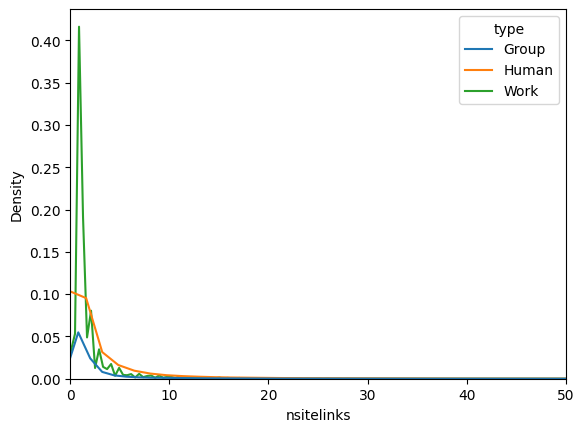

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data_wikidata, x="nsitelinks", hue="type")
plt.xlim(0,50)


# Merge 

In [226]:
data_artists = pd.merge(
        data, 
        data_wikidata.loc[data_wikidata.type.isin(["Group", "Human"])].add_suffix("_wd"), 
        left_on="performer", right_on="name_wd", how="left")

id_cols = ['set_id', 'ver_id', 'yt_id', 'title', 'performer', 'split', 'part', 'human_annotated']
agg_cols = ['id_wd', 'name_wd', 'nsitelinks_wd', 'type_wd', 'rank_wd', 'exposure_wd']


data_artists = data_artists[id_cols+agg_cols].groupby(id_cols, as_index=False).agg(
    {'id_wd': lambda x: list(x), 'type_wd': lambda x: list(x), 
     'nsitelinks_wd': ["min", "median", "max"], 
      'rank_wd': ["min", "median", "max"], 'exposure_wd': ["min", "median", "max"]})

n=5
mask_na = data_artists[('nsitelinks_wd', 'max')].isna()
print(f"{len(data_artists[mask_na])} not matched")
print(f"{n} random non-matched artists:")
data_artists.loc[mask_na].sample(n).performer.to_list()


45616 not matched
5 random non-matched artists:


['orchestra',
 'baseballs',
 'roberta hunt',
 'hal watters',
 'fourth grade nothing']

In [227]:
data_works = pd.merge(
    data,
    data_wikidata.loc[data_wikidata.type == "Work"].add_suffix("_wd"),
    left_on="title", right_on="name_wd", how="left")

id_cols = ['set_id', 'ver_id', 'yt_id', 'title', 'performer', 'split', 'part', 'human_annotated']
agg_cols = ['id_wd', 'nsitelinks_wd', 'type_wd', 'rank_wd', 'exposure_wd']

data_works = data_works[id_cols+agg_cols].groupby(id_cols, as_index=False).agg(
    {'id_wd': lambda x: list(x), 'type_wd': lambda x: list(x), 
     'nsitelinks_wd': ["min", "median", "max"], 
      'rank_wd': ["min", "median", "max"], 'exposure_wd': ["min", "median", "max"]})

n=5
mask_na = data_works[("exposure_wd", "max")].isna()
print(f"{len(data_works[mask_na])} not matched")
print(f"{n} random non-matched works:")
data_works.loc[mask_na].sample(n).title.to_list()



72317 not matched
5 random non-matched works:


["there's a boat that's leavin' soon for new york",
 'rock around with ollie vee',
 'chant des canons',
 'havana affair',
 'a nightingale sang in berkeley square']

In [228]:

__artists = data_artists[["set_id", "performer", "nsitelinks_wd", "exposure_wd"]].dropna().drop_duplicates()
wd_cols = ["set_id", "name", "sitelinks_min", "sitelinks_median", "sitelinks_max", "exposure_min", "exposure_median", "exposure_max"]
__artists.columns = wd_cols
__artists["Entity"] = "Artist"

__works = data_works[["set_id", "title", "nsitelinks_wd", "exposure_wd"]].dropna().drop_duplicates()
__works.columns = wd_cols
__works["Entity"] = "WoA"

data_merged = pd.concat([__artists, __works])
data_merged


,set_id,name,sitelinks_min,sitelinks_median,sitelinks_max,exposure_min,exposure_median,exposure_max,Entity
0,0,helen jepson,3.0,3.0,3.0,1.805220,1.805220,1.805220,Artist
1,0,billie holiday,84.0,84.0,84.0,7.729430,7.729430,7.729430,Artist
6,0,the ravens,1.0,3.0,5.0,1.008419,1.654876,2.301332,Artist
7,0,ethel waters,32.0,32.0,32.0,5.243087,5.243087,5.243087,Artist
8,0,jane powell,33.0,33.0,33.0,5.305492,5.305492,5.305492,Artist
...,...,...,...,...,...,...,...,...,...
129258,9982,two hearts,0.0,1.0,7.0,0.159121,1.008419,2.659496,WoA
129291,9988,happy days,2.0,2.0,2.0,1.478307,1.478307,1.478307,WoA
129307,9990,shape of things to come,3.0,3.5,4.0,1.805220,1.937514,2.069807,WoA
129318,9993,53rd & 3rd,7.0,7.0,7.0,2.659496,2.659496,2.659496,WoA


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


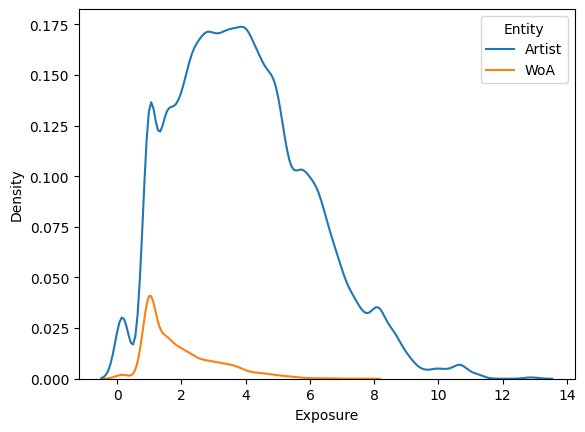

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data_merged, x="exposure_max", hue="Entity")
plt.xlabel("Exposure")
plt.savefig("../figures/kde_exposure.pdf")
plt.show()


In [230]:
our_artists = data_merged.loc[data_merged.Entity == "Artist"].name.to_list()
our_woas = data_merged.loc[data_merged.Entity == "WoA"].name.to_list()


# Check overlap with MuscRecoNER

### Load MusicRecoNER

In [388]:
import pandas as pd

data_reconer = pd.DataFrame()

for i in range(1, 5):
    __data = pd.read_csv(f"../baseline/music-ner-eacl2023/data/dataset{i}/ground-truth_linked.csv")
    __data["subset"] = f"dataset{i}"
    data_reconer = pd.concat([data_reconer, __data])






In [389]:
import sys
sys.path.append("..")
from preprocessing.Utils import remove_brackets_and_all_content

data_reconer["wiki_name_normalized"] = data_reconer.wiki_name.str.lower().str.replace("_", " ").apply(
    lambda x: remove_brackets_and_all_content(x) if isinstance(x, str) else x)


# Stratified Joint Datasets --> Reddit+SHS-YT

In [390]:
mapping = data_merged[["Entity", "name", "set_id"]].set_index(["Entity", "name"]).to_dict()["set_id"]

# add our set_id
data_reconer["set_id"] = data_reconer.apply(lambda x: mapping.get((x.type, x.wiki_name_normalized)), axis=1)
data_reconer["set_id"].notna().value_counts()


set_id
False    1860
True      338
Name: count, dtype: int64

In [391]:
from src.Utils import read_IOB_file

def get_music_reconer(path: str = "../data/dataset/reddit"):
    data = pd.DataFrame()
    for i in range(1, 5):
        words, tags = read_IOB_file(os.path.join(path, f"dataset{i}/test.IOB"))
        __data = pd.DataFrame()
        __data["query"] = [' '.join(ws) for ws in words]
        __data["IOB"] = tags
        __data["dataset"] = f"dataset{i}"
        __data["idx"] = [i for i in range(len(__data))]

        data = pd.concat([data, __data])
    return data

data_reconer = pd.merge(get_music_reconer(), data_reconer, on="query", how="left")
data_reconer["TEXT"] = data_reconer["query"].str.split()
data_reconer["id"] = data_reconer.apply(lambda x: x.dataset + '_' + str(x.idx), axis=1)
data_reconer["Origin"] = "Reddit"


In [395]:
data_ours = pd.read_parquet("../data/dataset/shsyt/data.parquet").query("human_annotated")
data_ours["id"] = data_ours.apply(lambda x: str(x.set_id) + '_' + x.yt_id, axis=1)
data_ours["Origin"] = "YouTube"


In [396]:
data_joint = pd.concat([
    data_ours[["id", "set_id", "Origin", "TEXT", "IOB"]],
    data_reconer[["id", "set_id", "Origin", "TEXT", "IOB"]]
    ])
#data_joint.set_id = data_joint.set_id.fillna(-1).astype(int)


In [397]:
# Origin
y = (data_joint.Origin == "YouTube").values.astype(int)

# Class ID
groups = data_joint.set_id.values

# Dummy values
X = data_joint.index


In [398]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=3)

for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"         group={groups[train_index]}")
    print(f"  Test:  index={test_index}")
    print(f"         group={groups[test_index]}")


Fold 0:
  Train: index=[   2    3    4    5    8    9   10   11   12   13   14   16   17   20
   21   22   23   24   25   34   35   37   38   39   40   41   42   43
   46   47   48   49   50   51   54   56   57   59   62   64   65   67
   68   70   71   73   74   76   77   79   80   82   83   85   86   88
   89   91   92   94   95   97   98  100  101  103  104  106  107  109
  110  112  113  115  116  118  119  121  122  124  125  126  127  129
  130  131  132  134  135  137  138  140  141  143  144  146  147  149
  150  152  153  155  156  160  161  163  164  166  167  168  169  170
  171  173  174  176  177  181  182  183  184  186  187  189  190  192
  193  195  196  198  199  201  202  204  205  207  208  210  211  213
  214  216  217  219  220  222  223  224  225  227  228  230  231  233
  234  236  237  239  240  242  243  245  248  250  251  253  254  256
  257  259  260  261  262  264  265  267  268  269  270  271  273  274
  276  277  279  280  281  282  284  285  287  288  29

In [294]:
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

X = np.ones((17, 2))
y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
sgkf = StratifiedGroupKFold(n_splits=3)
sgkf.get_n_splits(X, y)
print(sgkf)
for i, (train_index, test_index) in enumerate(sgkf.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"         group={groups[train_index]}")
    print(f"  Test:  index={test_index}")
    print(f"         group={groups[test_index]}")
    

StratifiedGroupKFold(n_splits=3, random_state=None, shuffle=False)
Fold 0:
  Train: index=[ 0  1  2  3  7  8  9 10 11 15 16]
         group=[1 1 2 2 4 5 5 5 5 8 8]
  Test:  index=[ 4  5  6 12 13 14]
         group=[3 3 3 6 6 7]
Fold 1:
  Train: index=[ 4  5  6  7  8  9 10 11 12 13 14]
         group=[3 3 3 4 5 5 5 5 6 6 7]
  Test:  index=[ 0  1  2  3 15 16]
         group=[1 1 2 2 8 8]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6 12 13 14 15 16]
         group=[1 1 2 2 3 3 3 6 6 7 8 8]
  Test:  index=[ 7  8  9 10 11]
         group=[4 5 5 5 5]


In [263]:
data_ours.set_id.unique()


array([  21,   58,   81,   96,  157,  214,  348,  350,  369,  484,  624,
        694,  724,  838, 1009, 1035, 1074, 1163, 1210, 1280, 1333, 1385,
       1397, 1521, 1536, 1848, 1919, 1928, 2156, 2286, 2487, 2619, 3147,
       3220, 3521, 3828, 4148, 7031, 7072, 8143, 8150, 8161, 8166, 8181,
       8188, 8190, 8209, 8210, 8218, 8222, 8231, 8234, 8240, 8249, 8251,
       8260, 8290, 8293, 8306, 8311, 8314, 8323, 8325, 8328, 8332, 8381,
       8385, 8389, 8431, 8447, 8458, 8486, 8493, 8497, 8534, 8541, 8544,
       8551, 8571, 8578, 8601, 8604, 8605, 8617, 8643, 8649, 8652, 8653,
       8669, 8674, 8675, 8694, 8701, 8712, 8714, 8743, 8760, 8773, 8777,
       8814, 8824, 8826, 8827, 8849, 8853, 8857, 8862, 8874, 8880, 8883,
       8885, 8887, 8931, 8939, 8945, 8955, 8959, 8965, 8992, 8996, 9001,
       9012, 9033, 9034, 9089, 9090, 9095, 9099, 9161, 9165, 9198, 9202,
       9212, 9215, 9238, 9269, 9282, 9284, 9291, 9295, 9298, 9299, 9314,
       9320, 9321, 9322, 9332, 9353, 9373, 9447, 94